In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys

os.environ['DYLD_LIBRARY_PATH']        = os.path.join(os.environ.get('CONDA_PREFIX',''), 'lib')
os.environ['DYLD_FALLBACK_LIBRARY_PATH'] = ''
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import cv2
import os
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from scipy.ndimage import rotate
import pprint
import sims
import SimpleITK as sitk
import tifffile

from mims.services.image_utils import image_from_im_file
from mims.services.register import validate_mims_image, get_mims_dims, get_points_transform, polygon_centroid, _flip_x



objc[45696]: Class GNotificationCenterDelegate is implemented in both /Users/chris/miniforge3/envs/emb/lib/libgio-2.0.0.dylib (0x16a96a408) and /opt/homebrew/Cellar/glib/2.84.3/lib/libgio-2.0.0.dylib (0x300f8c4b8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.


In [ ]:
from mims.models import Canvas
from mims.services.register2 import stitch_canvas

# ─────────────────────────── example call ────────────────────────────────────────
# for canvas in "75_6hrfast_M2",
for canvas in Canvas.objects.all():
    print(f"Starting {canvas}...")
    stitch_canvas(canvas)


Starting 73_6hrfast_M1...
Stitching a49c7172-8f55-4960-9752-8b669b20014d - from 2025-03-31 14:16:20.562907+00:00
Error registering 78e37df5-101e-478e-b692-3b7ea8233316: Shape file not found: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a49c7172-8f55-4960-9752-8b669b20014d/mims_images/73_ROI_5/registration/reg_shapes.json
Error registering 7a04498b-4f8b-4b18-a867-cef62f41dcb0: Shape file not found: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a49c7172-8f55-4960-9752-8b669b20014d/mims_images/73_ROI_6/registration/reg_shapes.json
Error registering 826c3568-5b06-46f5-adb3-acb2a1cc20cf: Shape file not found: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a49c7172-8f55-4960-9752-8b669b20014d/mims_images/73_ROI_7/registration/reg_shapes.json
Error registering f29b2bdf-d647-40d7-888a-18d6022d1d1f: Shape file not found: /Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a49c7172-8f55-

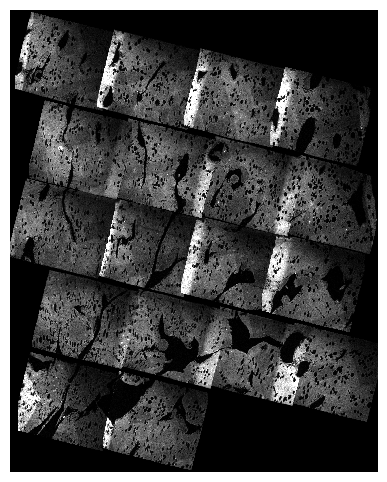

In [5]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# replace with your path
filename_base = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims/mosaics/"
fn_end = "set_34de9890-d880-46d9-9ee3-ccd9f2cad94c/32S/mosaic_20250708T042940_32S.tif"
filename = filename_base + fn_end
arr = tifffile.imread(filename, key=0)    # e.g. shape (H,W) or (H,W,2)

# 3) Extract only the luma channel if needed
if arr.ndim == 3 and arr.shape[2] == 2:
    arr = arr[..., 0]


# 4) If uint16, rescale to uint8 so PIL autocontrast works
# but rescale to only 99th percentile of non-zero pixels
max_val = np.percentile(arr[arr > 0], 99)
arr = np.clip(arr, 0, max_val)

if arr.dtype == np.uint16:
    arr = arr.astype(np.float32)
    arr = ( (arr - arr.min()) / (arr.max() - arr.min()) * 255.0 ).astype(np.uint8)
elif arr.dtype != np.uint8:
    # fallback: clamp to 0–255
    arr = np.clip(arr, 0, 255).astype(np.uint8)

# 5) Create PIL image, autocontrast, and plot
im    = Image.fromarray(arr, mode="L")
im_ac = ImageOps.autocontrast(im)

plt.figure(figsize=(6,6))
plt.imshow(im_ac, cmap="gray", interpolation="nearest")
plt.axis("off")
plt.show()

In [ ]:
from mims.models import Canvas
for canvas in Canvas.objects.all():
    for mims_image_set in MIMSImageSet.objects.filter(canvas=canvas):
        mims_image_set.status = "COMPLETE"
        mims_image_set.save()

In [11]:
import tifffile

path = "/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims/mosaics/set_937c681b-80c9-4b8e-b69c-30cb8787e650/14N_12C/mosaic_20250708T221828_14N_12C.tif"
with tifffile.TiffFile(path) as tif:
    for i, page in enumerate(tif.pages):
        offs = page.tags["TileOffsets"].value
        cnts = page.tags["TileByteCounts"].value
        print(f"IFD {i:02d}  subifd={page.is_subifd}  tiles={page.shape[1]//512}×{page.shape[0]//512}")
        print(f"  offsets: {len(offs)} entries, byteCounts: {len(cnts)} entries")


IFD 00  subifd=False  tiles=82×50
  offsets: 4233 entries, byteCounts: 4233 entries
